In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
!pip install openpyxl
from collections import defaultdict
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import LogNorm

# Parameters

In [2]:
save = False
input_clustering = '_new' # '_new' or ''
optimal_cluster = 'st_cluster_final_gid' # 'st_cluster_final_gid' or 'st_cluster_3_5_7'

test_case = 'block'
historic_ref = '' # '_Full' '_Discount' or ''
premium_type = '' # '_Full'  '_Discount' or ''

use_reinsurance = True
base_case = ''
if use_reinsurance == False:
    base_case = '_base_case'

In [3]:
if test_case == 'historic':
    simulations = 1
else:
    steps = 100
    simulations = 1000

# Data Load

## Simulations

In [4]:
# Simulation data
state_balance_df = pd.read_csv(f'Results/state_balance_{test_case}{input_clustering}{premium_type}{base_case}.csv')
final_balances_df = pd.read_csv(f'Results/final_balances_{test_case}{input_clustering}{premium_type}{base_case}.csv')
cluster_state_df = pd.read_csv(f'Results/cluster_state_{test_case}{input_clustering}{premium_type}{base_case}.csv')
balance_transition_df = pd.read_csv(f'Results/balance_transition_{test_case}{input_clustering}{premium_type}{base_case}.csv')

# Historic data
state_balance_df_hist = pd.read_csv(f'Results/state_balance_historic{input_clustering}{historic_ref}.csv')

## Geospatial

In [5]:
# Geospatial data
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)
gdf_states["STATEFP"] = pd.to_numeric(gdf_states["STATEFP"], errors="coerce").astype("Int64")

## NFIP Clustered Claims

In [6]:
if input_clustering == '_new':
    clustered_claims = pd.read_csv("../2_Low_Return_Period/new_clusters_9.24.25.csv")
    optimal_cluster = 'st_cluster_final_gid'
else:
    clustered_claims = pd.read_csv("../2_Low_Return_Period/Clusters/2025_all/clustered_claims_sensitivity.csv")

clustered_claims['countyCode']=clustered_claims['countyCode'].apply(lambda x: str(x).zfill(5))
clustered_claims['stateCode']=clustered_claims['countyCode'].str[:2]

/tmp/ipykernel_612/1877075091.py:2: DtypeWarning: Columns (7,51,66) have mixed types. Specify dtype option on import or set low_memory=False.
  clustered_claims = pd.read_csv("../2_Low_Return_Period/new_clusters_9.24.25.csv")


In [7]:
# Create the new field 'percentageDamageAmount'
clustered_claims['percentageBuildingDamageAmount'] = ((clustered_claims['buildingDamageAmount'] / clustered_claims['buildingPropertyValue']) * 100).clip(upper=100)
# Create new field for 'totalClaimPaid'
clustered_claims['totalClaimPaid'] = clustered_claims['amountPaidOnBuildingClaim'].fillna(0) + clustered_claims['amountPaidOnContentsClaim'].fillna(0)
# Filter stateOwnedIndicator is True
clustered_claims = clustered_claims[clustered_claims['stateOwnedIndicator'] != True]

In [8]:
# Load CPI data
CPI_insurance = pd.read_csv("../Local_Data/BLS_Data/US_BLS_CPIAUCSL.csv", parse_dates=["DATE"]) 

# Ensure 'CPIAUCSL' is numeric
CPI_insurance["CPIAUCSL"] = pd.to_numeric(CPI_insurance["CPIAUCSL"], errors="coerce")

# Handle missing or non-numeric values by forward and backward filling
CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
CPI_insurance["CPIAUCSL"].fillna(method="bfill", inplace=True)

# Extract year and calculate annual average CPI
CPI_insurance['Year'] = CPI_insurance["DATE"].dt.year
CPI_insurance = CPI_insurance.groupby('Year')["CPIAUCSL"].mean().reset_index()
CPI_insurance = CPI_insurance.rename(columns={"CPIAUCSL": "CPI"})

# Base CPI for adjustment (e.g., 2024)
BASE_CPI = 313.3

# Filter claims to only include those from 1998 to present
clustered_claims['dateOfLoss'] = pd.to_datetime(clustered_claims['dateOfLoss'])

# Extract month (abbreviated) and year from 'dateOfLoss'
clustered_claims.loc[:, 'yearOfLoss'] = clustered_claims['dateOfLoss'].dt.year

# Merge clustered_claims with CPI_insurance on month (abbreviation) and year
claims_merged = pd.merge(clustered_claims, CPI_insurance, left_on=['yearOfLoss'], right_on=['Year'])

# Create 'adjustedClaim' column by dividing the CPI for May 2024 by the CPI at the time of loss, and multiplying by 'totalClaimPaid'
claims_merged['adjustedClaim'] = (BASE_CPI / claims_merged['CPI']) * claims_merged['totalClaimPaid']

# Drop unnecessary columns and keep relevant ones
adjusted_claims = claims_merged[['dateOfLoss', 'totalClaimPaid', 'adjustedClaim', 'yearOfLoss']]

clustered_claims = claims_merged

/tmp/ipykernel_612/2656989844.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_612/2656989844.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  CPI_insurance["CPIAUCSL"].fillna(method="ffill", inplace=True)
/tmp/ipykernel_612/2656989844.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inp

## NFIP Policies

In [9]:
if premium_type == '_Full':
    risk_policies = pd.read_excel('../Local_Data/NFIP_Data/updatedNFIPdata_2025.xlsx', sheet_name='2024')
    risk_policies['County Code'] = risk_policies['County Code'].astype(int).astype(str)
    risk_policies['County Code'] = risk_policies['County Code'].apply(lambda x: str(x).zfill(5))
    risk_policies['State'] = risk_policies['State Names'].str.strip().str.upper()
    risk_policies['Policies in Force'] = risk_policies['Policy Count']
    
    aggregated_risk_policies = risk_policies.groupby(['County Code', 'State']).agg({
        'Policies in Force': 'sum',
        'Total Written Premium + FPF': 'sum',
        'Total Annual Payment': 'sum'
    }).reset_index()

elif premium_type == '_Discount':
    risk_policies = pd.read_csv('../Local_Data/NFIP_Data/UpdatedNFIPData_2024_V4.csv')
    risk_policies['countyCode'] = risk_policies['countyCode'].astype(int).astype(str)
    risk_policies['countyCode'] = risk_policies['countyCode'].apply(lambda x: str(x).zfill(5))
    risk_policies['State'] = risk_policies['State Name'].str.strip().str.upper()
    risk_policies['Policies in Force'] = risk_policies['TotalPolicies']
    risk_policies['Total Written Premium + FPF'] = risk_policies['actualPremium'] + risk_policies['federalPolicyFee']
    
    aggregated_risk_policies = risk_policies.groupby(['countyCode', 'State']).agg({
        'Policies in Force': 'sum',
        'Total Written Premium + FPF': 'sum',
        'Total Annual Payment': 'sum'
    }).reset_index()

else:
    risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

    risk_policies['County'] = risk_policies['County'].str.strip()
    risk_policies['State'] = risk_policies['State'].str.strip()
    
    aggregated_risk_policies = risk_policies.groupby(['County', 'State']).agg({
        'Policies in Force': 'sum',
        'Total Written Premium + FPF': 'sum',
        'Total Annual Payment': 'sum'
    }).reset_index()

In [10]:
# Manually create the dictionary mapping state FIPS codes to state names
state_fips_dict = {
    "01": "ALABAMA",
    "02": "ALASKA",
    "04": "ARIZONA",
    "05": "ARKANSAS",
    "06": "CALIFORNIA",
    "08": "COLORADO",
    "09": "CONNECTICUT",
    "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA",
    "12": "FLORIDA",
    "13": "GEORGIA",
    "15": "HAWAII",
    "16": "IDAHO",
    "17": "ILLINOIS",
    "18": "INDIANA",
    "19": "IOWA",
    "20": "KANSAS",
    "21": "KENTUCKY",
    "22": "LOUISIANA",
    "23": "MAINE",
    "24": "MARYLAND",
    "25": "MASSACHUSETTS",
    "26": "MICHIGAN",
    "27": "MINNESOTA",
    "28": "MISSISSIPPI",
    "29": "MISSOURI",
    "30": "MONTANA",
    "31": "NEBRASKA",
    "32": "NEVADA",
    "33": "NEW HAMPSHIRE",
    "34": "NEW JERSEY",
    "35": "NEW MEXICO",
    "36": "NEW YORK",
    "37": "NORTH CAROLINA",
    "38": "NORTH DAKOTA",
    "39": "OHIO",
    "40": "OKLAHOMA",
    "41": "OREGON",
    "42": "PENNSYLVANIA",
    "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA",
    "47": "TENNESSEE",
    "48": "TEXAS",
    "49": "UTAH",
    "50": "VERMONT",
    "51": "VIRGINIA",
    "53": "WASHINGTON",
    "54": "WEST VIRGINIA",
    "55": "WISCONSIN",
    "56": "WYOMING"
}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

In [11]:
state_abbrev_dict = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA',
    '08': 'CO', '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL',
    '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL', '18': 'IN',
    '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME',
    '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS',
    '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND',
    '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI',
    '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', '49': 'UT',
    '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI',
    '56': 'WY'
}

In [12]:
state_claims = pd.read_csv('../Local_Data/NFIP_Data/All_Claims_by_Year.csv')
state_claims = state_claims.groupby("State").aggregate({'Total Claim Dollars Paid':'mean','Total Paid Claims':'mean'}).reset_index()
state_claims['State'] = state_claims['State'].str.upper()
state_claims = state_claims.merge(state_df, left_on='State', right_on='State Name', how='left')
state_policies = aggregated_risk_policies.groupby("State").aggregate({
    'Policies in Force':'sum',
    'Total Written Premium + FPF':'sum',
    'Total Annual Payment':'sum'}).reset_index()
state_merged = state_claims.merge(state_policies, left_on='State', right_on='State', how='left')
state_merged['meanLoss'] = state_merged['Total Written Premium + FPF']-state_merged['Total Claim Dollars Paid']

# Merge the aggregated data with the shapefile
gdf_states = gdf_states.merge(state_merged, left_on='GEOID', right_on='State FIPS', how='left')

In [13]:
# Step 1: Compute total premium
total_premium = gdf_states["Total Written Premium + FPF"].sum()

# Step 2: Create a new column for percentage of total
gdf_states["Contribution %"] = 100 * gdf_states["Total Written Premium + FPF"] / total_premium

# Step 3: Create a new column for value of the pool
gdf_states["Benefit"] = 100 / gdf_states["Contribution %"]
gdf_states["OG_Benefit"] = gdf_states["Benefit"]
og_gain_balance = np.min(gdf_states["Benefit"])

# Step 4: Create a new column for the withdrawal max
gdf_states["Withdrawal_threshold"] = gdf_states["Total Written Premium + FPF"]*og_gain_balance
gdf_states["OG_Withdrawal_threshold"] = gdf_states["Withdrawal_threshold"]

# Remove AL and HI for simulation
gdf_states = gdf_states[~gdf_states['State'].isin(['ALASKA', 'HAWAII'])]

# Plotting

# Benefit and Strain

In [14]:
# Sum reinsurance used and final balance per state
re_summary = (
    cluster_state_df.groupby("STATEFP")[["re_covered"]]
    .sum()
    .reset_index()
)

balance_summary = (
    final_balances_df.groupby("STATEFP")[["nfip_balance"]]
    .mean()  # or .last() if only using final year
    .reset_index()
)

premium_summary = (
    gdf_states[["STATEFP", "Total Written Premium + FPF"]]
    .rename(columns={"Total Written Premium + FPF": "premium"})
)

# Merge all together
summary_df = (
    re_summary
    .merge(balance_summary, on="STATEFP", how="outer")
    .merge(premium_summary, on="STATEFP", how="left")
)

# Drop states with zero or missing premium
summary_df = summary_df[summary_df["premium"] > 0].copy()
summary_df["premium"] = summary_df["premium"].replace(0, np.nan)

# --- Derived Metrics ---
summary_df["Norm_re"] = summary_df["re_covered"] / summary_df["premium"] /1000
summary_df["Norm_balance"] = summary_df["nfip_balance"] / summary_df["premium"] /100

# System-wide benefit
total_balance = summary_df["nfip_balance"].sum()
total_premiums = summary_df["premium"].sum()
epsilon = 1

summary_df["Net_benefit"] = total_balance / summary_df["nfip_balance"].clip(lower=total_balance/10000)
neg_def = total_balance
summary_df["Original_benefit"] = total_premiums / summary_df["premium"]
summary_df["Norm_strain"] = (summary_df["Net_benefit"] - summary_df["Original_benefit"]) / summary_df["Net_benefit"]

# Merge back to gdf_states for plotting
gdf_plot = gdf_states.merge(summary_df, on="STATEFP", how="left")

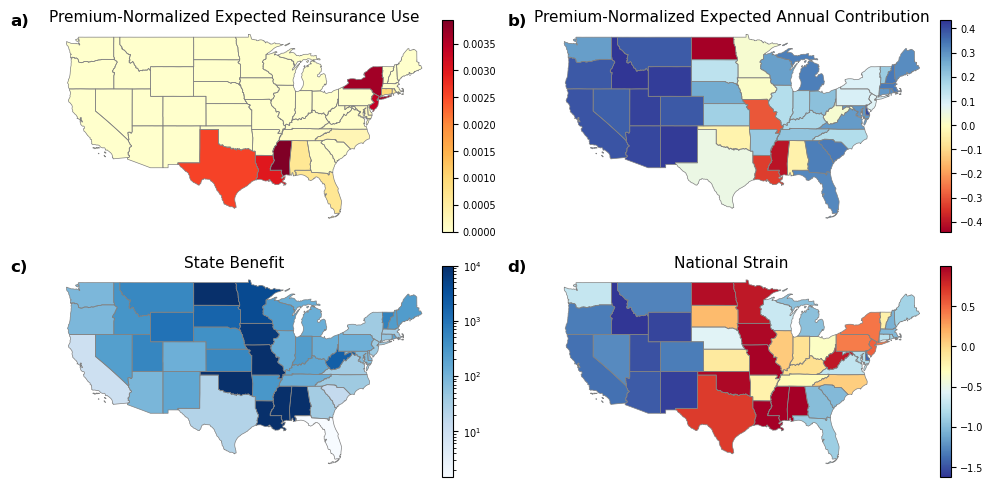

In [15]:
# Panel metadata
plot_data = [
    ("Norm_re", "Premium-Normalized Expected Reinsurance Use", "a)", lambda v: f"{v:.1f}", "YlOrRd", None, ""),
    ("Norm_balance", "Premium-Normalized Expected Annual Contribution", "b)", lambda v: f"{v:.0f}", "RdYlBu", None, ""),
    ("Net_benefit", "State Benefit", "c)", lambda v: f"1e{int(np.round(np.log10(v)))}" if v > 0 else "0", "Blues",
     LogNorm(vmin=gdf_plot["Net_benefit"].replace(0, np.nan).min(), vmax=gdf_plot["Net_benefit"].max()), ""),
    ("Norm_strain", "National Strain", "d)", lambda v: f"{v:.1f}", "RdYlBu_r", None, ""),
]

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
extent = [-130, -65, 24, 50]
x_min, x_max, y_min, y_max = extent
skip_labels = {"DC", "RI", "CT", "DE", "MD", "NH"}

for i, (ax, (col, title, label, fmt_fn, cmap, norm, cbar_label)) in enumerate(zip(axs.flat, plot_data)):
    gdf_plot.plot(
        column=col, cmap=cmap, linewidth=0.1, ax=ax,
        norm=norm, legend=False
    )
    gdf_plot.boundary.plot(ax=ax, color="grey", linewidth=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis("off")
    ax.set_title(title, fontsize=11)

    #if i in [2, 3]:
    """
    for idx, row in gdf_plot.iterrows():
        abbr = row["STUSPS"]
        rep_point = row.geometry.representative_point()
        x, y = rep_point.x, rep_point.y
        val = row[col]
        if abbr in skip_labels or np.isnan(val):
            continue
        ax.text(x, y, fmt_fn(val), ha='center', va='center', fontsize=6, color='black')
    """
    
    ax.text(-0.06, 1.02, label, transform=ax.transAxes, size=12, weight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm if norm else plt.Normalize(
        vmin=gdf_plot[col].min(), vmax=gdf_plot[col].max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label(cbar_label, fontsize=8)
    cbar.ax.tick_params(labelsize=7)

plt.tight_layout()
if save:
    plt.savefig(f"Plots/New/Strain_Reinsurance4_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()